<a href="https://colab.research.google.com/github/Pradhyumn1/plant_dis/blob/main/projects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML


In [4]:
# Set your desired image size
BATCH_SIZE = 32
IMAGE_SIZE = (256,256)
CHANNELS=3
EPOCHS=50

In [5]:
import os
import tensorflow as tf

# Specify your dataset path
dataset_path = '/content/drive/MyDrive/btp2/PlantVillage'


In [6]:
#dataset_path = '/content/gdrive/MyDrive/btp2/PlantVillage'

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    seed=123,
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)


Found 2172 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

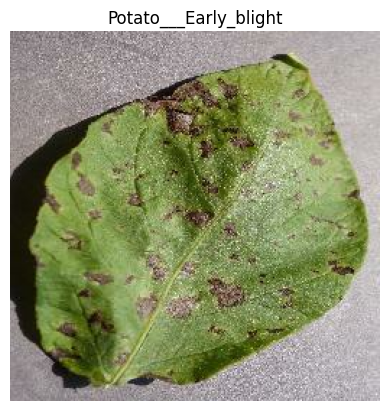

In [8]:
for image_batch, labels_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.title(class_names[labels_batch[0]])
    plt.axis('off')

In [9]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 1 2 0 0 1 0 0 1 1 0 2 0 0 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 1]


**Visualize some of the images from our dataset**

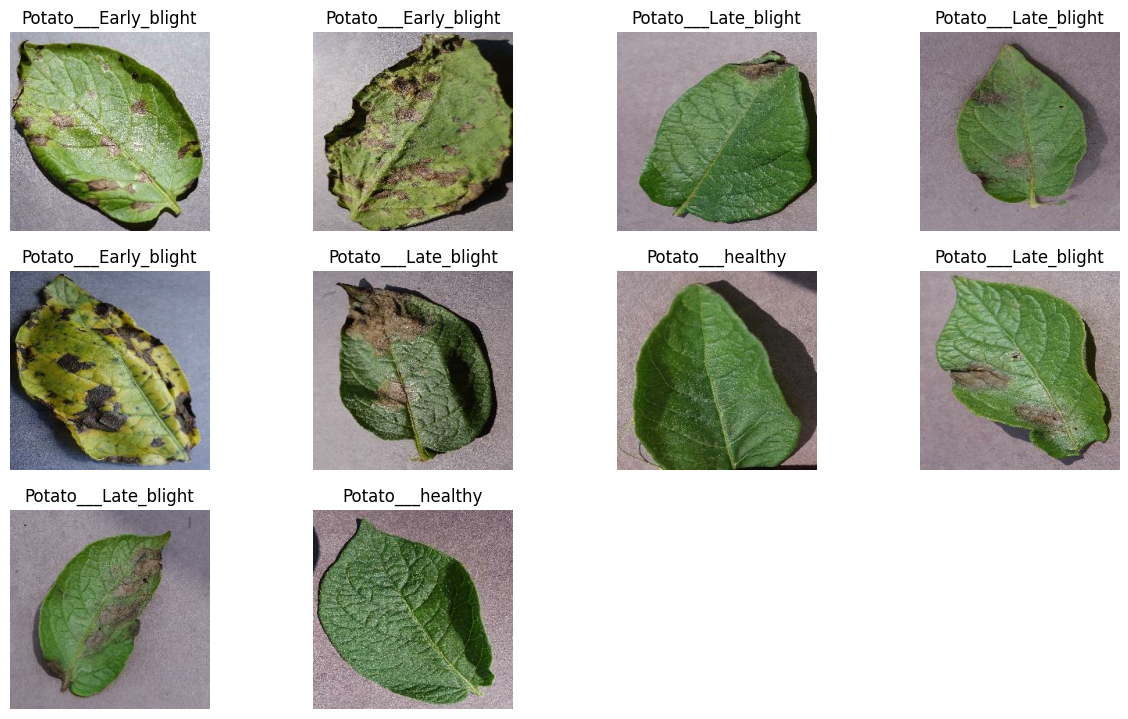

In [10]:
plt.figure(figsize=(15,15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [11]:
len(dataset)


68

In [12]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [13]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

54

In [17]:
len(val_ds)

6

In [18]:
len(test_ds)

8

**Cache, Shuffle, and Prefetch the Dataset**

In [19]:
# Cache, Shuffle, and Prefetch the Dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [20]:
# Building the Model

# Using Functional API for more flexibility
input_layer = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], CHANNELS))
resized_and_rescaled = layers.experimental.preprocessing.Rescaling(1./255)(input_layer)

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])


In [22]:
# Apply data augmentation to the input data
augmented_data = data_augmentation(resized_and_rescaled, training=True)

In [23]:
# Build the rest of the model architecture
x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(augmented_data)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)

In [24]:
# Output layer with softmax activation
output_layer = layers.Dense(10, activation='softmax')(x)

In [25]:

# Create the model using the functional API
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

In [26]:
# Compile the Model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Display Model Summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                             

In [27]:

# Training the Model

# Increase the number of epochs for better training
#epochs = 3

# Use model.fit instead of model.fit_generator, as it is more common in recent TensorFlow versions
my_model = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)


Epoch 1/50
54/54 [==============================] - 166s 172ms/step - loss: 1.2359 - accuracy: 0.4676 - val_loss: 0.9566 - val_accuracy: 0.4427
Epoch 2/50
54/54 [==============================] - 3s 60ms/step - loss: 0.9986 - accuracy: 0.4855 - val_loss: 0.8204 - val_accuracy: 0.5417
Epoch 3/50
54/54 [==============================] - 3s 62ms/step - loss: 0.8791 - accuracy: 0.6036 - val_loss: 0.6819 - val_accuracy: 0.7344
Epoch 4/50
54/54 [==============================] - 3s 60ms/step - loss: 0.6973 - accuracy: 0.7025 - val_loss: 0.4804 - val_accuracy: 0.8281
Epoch 5/50
54/54 [==============================] - 3s 59ms/step - loss: 0.5722 - accuracy: 0.7731 - val_loss: 0.3188 - val_accuracy: 0.8750
Epoch 6/50
54/54 [==============================] - 3s 59ms/step - loss: 0.4839 - accuracy: 0.8212 - val_loss: 0.3209 - val_accuracy: 0.8802
Epoch 7/50
54/54 [==============================] - 3s 62ms/step - loss: 0.4295 - accuracy: 0.8287 - val_loss: 0.3419 - val_accuracy: 0.8698
Epoch 8/50

In [28]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 33ms/step - loss: 0.0294 - accuracy: 0.9844


In [29]:
scores

[0.029421906918287277, 0.984375]

In [30]:
## acuracy curve

In [31]:
my_model

In [32]:
my_model.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [33]:
my_model.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
type(my_model.history['loss'])

list

In [35]:
len(my_model.history['loss'])

50

In [36]:
# Access accuracy history without the % sign
acc = my_model.history['accuracy']
val_acc = my_model.history['val_accuracy']

loss = my_model.history['loss']
val_loss = my_model.history['val_loss']


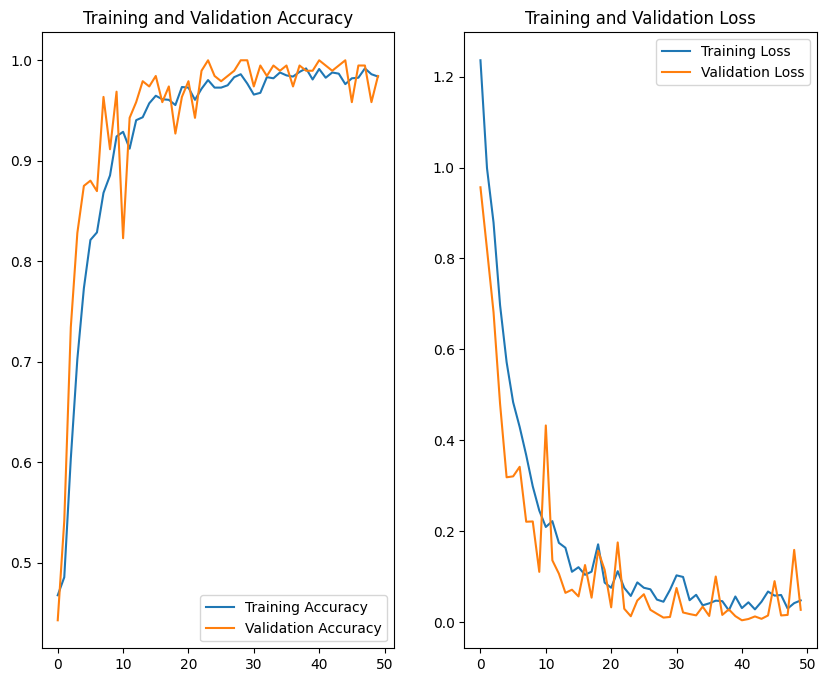

In [37]:
import numpy as np
# Assuming EPOCHS is set to the correct number of epochs
epochs_range = np.linspace(0, EPOCHS, len(acc), endpoint=False)

plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 434ms/step
predicted label: Potato___Late_blight


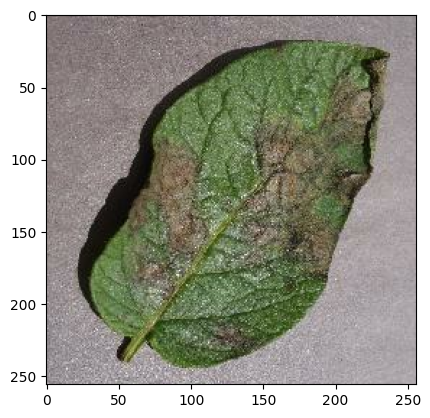

In [38]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [39]:
# inference function
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


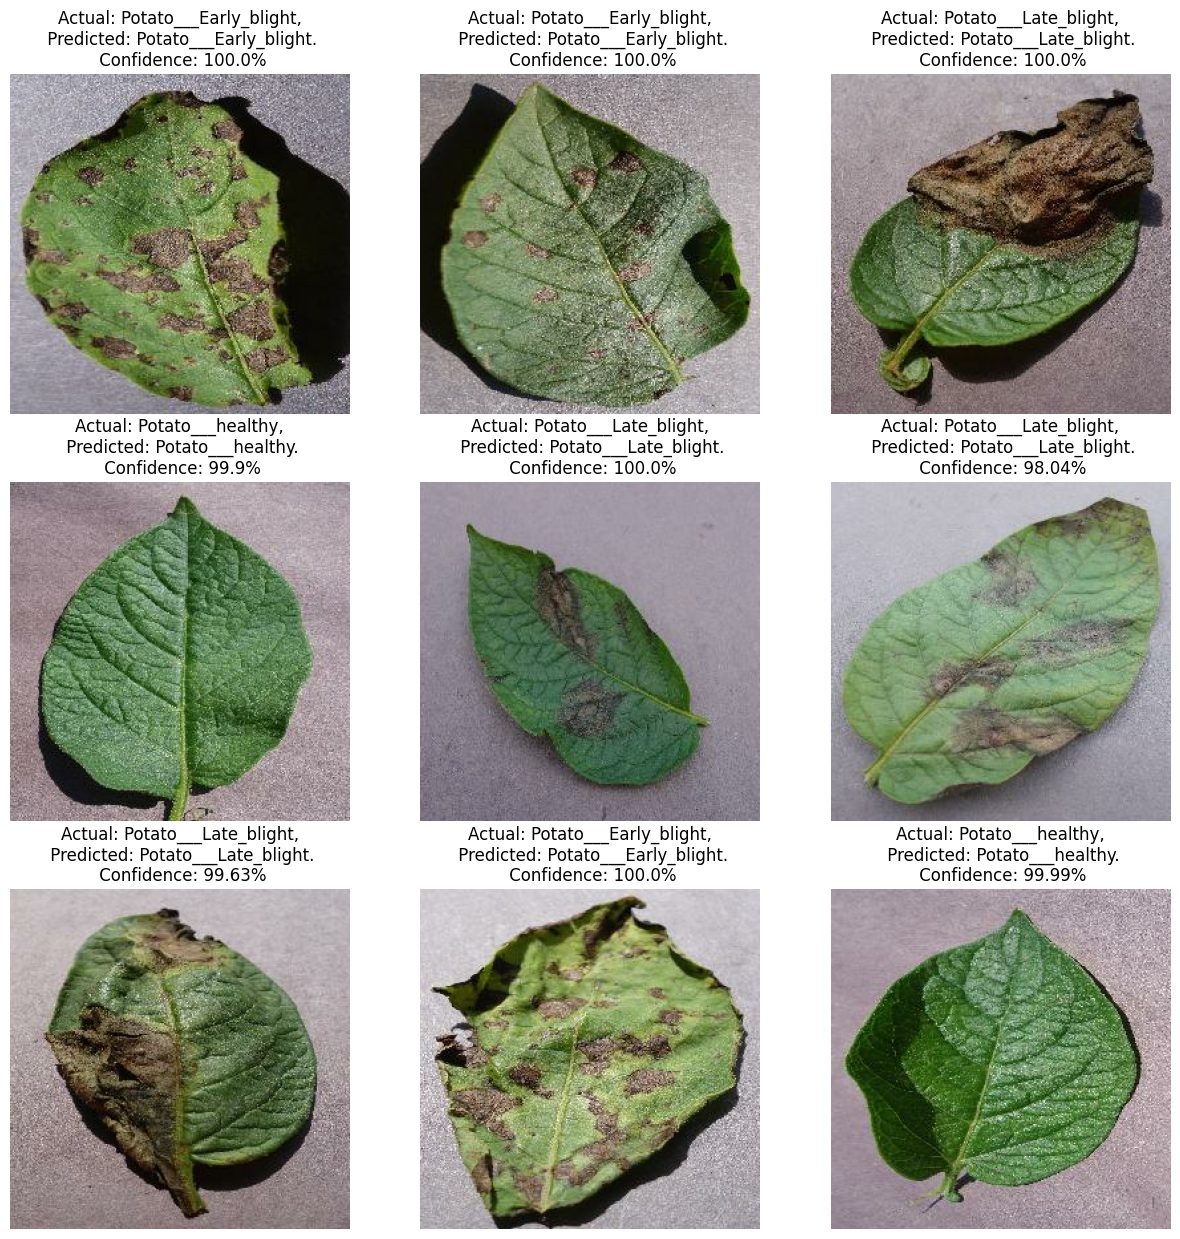

In [40]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [41]:
!pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.4 MB/s eta 0:00:00


In [42]:
#!pip install mlflow
import mlflow

# Save your model using MLflow
with mlflow.start_run():
    mlflow.log_param("model_name", "r")
    mlflow.sklearn.log_model(model, "model")

2024/01/04 23:10:12 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.4.23+cuda12.cudnn89) contains a local version label (+cuda12.cudnn89). MLflow logged a pip requirement for this package as 'jaxlib==0.4.23' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [47]:
import shutil

# Download the saved model from Colab to your local machine
local_model_path = "path/to/local/folder"
mlflow.sklearn.save_model(model, local_model_path)
shutil.make_archive(local_model_path, 'zip', local_model_path)


2024/01/04 21:47:09 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.4.23+cuda12.cudnn89) contains a local version label (+cuda12.cudnn89). MLflow logged a pip requirement for this package as 'jaxlib==0.4.23' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


'/content/path/to/local/folder.zip'

In [45]:
# # Install MLflow
# !pip install mlflow
!pip install flask_ngrok

# Start MLflow server locally
!mlflow server --host=0.0.0.0 --port=5000 --backend-store-uri sqlite:///mlflow.db --default-artifact-root file:/tmp/artifacts &

# Expose MLflow server on ngrok (temporary solution for Colab)
!pip install pyngrok
from pyngrok import ngrok

# Setup a tunnel to the MLflow UI
public_url = ngrok.connect(port='5000')

public_url


[2024-01-04 23:13:00 +0000] [8010] [INFO] Starting gunicorn 21.2.0
[2024-01-04 23:13:00 +0000] [8010] [INFO] Listening at: http://0.0.0.0:5000 (8010)
[2024-01-04 23:13:00 +0000] [8010] [INFO] Using worker: sync
[2024-01-04 23:13:00 +0000] [8011] [INFO] Booting worker with pid: 8011
[2024-01-04 23:13:00 +0000] [8012] [INFO] Booting worker with pid: 8012
[2024-01-04 23:13:00 +0000] [8017] [INFO] Booting worker with pid: 8017
[2024-01-04 23:13:01 +0000] [8018] [INFO] Booting worker with pid: 8018
[2024-01-04 23:28:41 +0000] [8010] [INFO] Handling signal: int
[2024-01-04 23:28:41 +0000] [8018] [INFO] Worker exiting (pid: 8018)
[2024-01-04 23:28:41 +0000] [8017] [INFO] Worker exiting (pid: 8017)
[2024-01-04 23:28:41 +0000] [8011] [INFO] Worker exiting (pid: 8011)
[2024-01-04 23:28:41 +0000] [8012] [INFO] Worker exiting (pid: 8012)
[2024-01-04 23:28:42 +0000] [8010] [INFO] Shutting down: Master


ERROR:pyngrok.process.ngrok:t=2024-01-04T23:28:48+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session obj=csess id=60110d9cf122 err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"


PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.